In [1]:
import pandas as pd
import numpy as np
import random
import copy
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier


from sklearn import tree
from sklearn import svm

from sklearn import metrics
from itertools import combinations

# Read in Data

In [2]:
import pandas as pd
data = pd.ExcelFile("OppScrData.xlsx")

In [3]:
data1 = data.parse(0)

In [4]:
# remove unnamed column
for i in data1:
    if i.startswith('Unnamed') or i.startswith('CLINICAL OUTCOMES') or i.startswith('AUTO-CT'):
        data1.pop(i)
    
data1 = data1.dropna(axis = 0,how='all') # Remove Rows with All NAS

# Create Binary Indicators

In [5]:
def replace_binary_indicator(df,c1,c2,t):
    if c2 != "":
        df.loc[df.loc[:,c1:c2].any(axis=1),t] = 1 
        df.loc[~df.loc[:,c1:c2].any(axis=1),t] = 0
        df = df.drop(df.loc[:,c1:c2],axis=1)
    else:
        df.loc[~df.loc[:,c1].isnull(),t] = 1 
        df.loc[df.loc[:,c1].isnull(),t] = 0
        df = df.drop(c1,axis=1)
    df[t] = df[t].astype(np.uint8)

    return df

In [6]:
data2 = data1.copy()
data2 = replace_binary_indicator(data2,"Alcohol abuse","","AA_FLAG")

data2 = replace_binary_indicator(data2,"CVD DX","MI DX Date [d from CT]","CARD_FLAG")
data2 = replace_binary_indicator(data2,"Type 2 Diabetes DX","Type 2 Diabetes DX Date [d from CT]","DIA_FLAG")
data2 = replace_binary_indicator(data2,"Femoral neck fracture DX","Pathologic fracture DX Date [d from CT]","FEM_FLAG")
data2 = replace_binary_indicator(data2,"Alzheimers DX","Alzheimers DX Date [d from CT]","ALZ_FLAG")
data2 = replace_binary_indicator(data2,"Primary Cancer Site","Primary Cancer Site 2 Dx [d from CT]","CANCER_FLAG")

data2["OUTCOME_FLAGS"] = data2.loc[:,"CARD_FLAG":"CANCER_FLAG"].sum(axis = 1)
data2["OUTCOME_FLAGS"] = pd.Categorical(data2["OUTCOME_FLAGS"])

data2 = replace_binary_indicator(data2,"DEATH [d from CT]","","DEATH_FLAG")
data2

# We do a reshuffle to "AA_Flag" is next to the other clinical data
data2 = pd.concat([data2.loc[:,"Record ID":"Met Sx"],data2.loc[:,"AA_FLAG"],data2.loc[:,"L1_HU_BMD":"Liver HU    (Median)"],data2.loc[:,"CARD_FLAG":"DEATH_FLAG"]], axis = 1)

# Create Column Index

In [7]:
# print column name with corresponding number
for count, name in enumerate(data2):
    print(f'{count}:"{name}",')

0:"Record ID",
1:"Visit ID",
2:"PT ID",
3:"Clinical F/U interval  [d from CT]",
4:"BMI",
5:"BMI >30",
6:"Sex",
7:"Age at CT",
8:"Tobacco",
9:"FRS 10-year risk (%)",
10:"FRAX 10y Fx Prob (Orange-w/ DXA)",
11:"FRAX 10y Hip Fx Prob (Orange-w/ DXA)",
12:"Met Sx",
13:"AA_FLAG",
14:"L1_HU_BMD",
15:"TAT Area (cm2)",
16:"Total Body                Area EA (cm2)",
17:"VAT Area (cm2)",
18:"SAT Area (cm2)",
19:"VAT/SAT     Ratio",
20:"Muscle HU",
21:" Muscle Area (cm2)",
22:"L3 SMI (cm2/m2)",
23:"AoCa        Agatston",
24:"Liver HU    (Median)",
25:"CARD_FLAG",
26:"DIA_FLAG",
27:"FEM_FLAG",
28:"ALZ_FLAG",
29:"CANCER_FLAG",
30:"OUTCOME_FLAGS",
31:"DEATH_FLAG",


In [8]:
# define a lookup table for the column
columns = {0:"Record ID",
1:"Visit ID",
2:"PT ID",
3:"Clinical F/U interval  [d from CT]",
4:"BMI",
5:"BMI >30",
6:"Sex",
7:"Age at CT",
8:"Tobacco",
9:"FRS 10-year risk (%)",
10:"FRAX 10y Fx Prob (Orange-w/ DXA)",
11:"FRAX 10y Hip Fx Prob (Orange-w/ DXA)",
12:"Met Sx",
13:"AA_FLAG",
14:"L1_HU_BMD",
15:"TAT Area (cm2)",
16:"Total Body                Area EA (cm2)",
17:"VAT Area (cm2)",
18:"SAT Area (cm2)",
19:"VAT/SAT     Ratio",
20:"Muscle HU",
21:" Muscle Area (cm2)",
22:"L3 SMI (cm2/m2)",
23:"AoCa        Agatston",
24:"Liver HU    (Median)",
25:"CARD_FLAG",
26:"DIA_FLAG",
27:"FEM_FLAG",
28:"ALZ_FLAG",
29:"CANCER_FLAG",
30:"OUTCOME_FLAGS",
31:"DEATH_FLAG",
}

# define different groups of column
clinical_data_columns = {i:columns[i] for i in range(14)}
CT_data = {i:columns[i] for i in range(14,25)}
clinical_outcome_columns = {i:columns[i] for i in range(25,32)}

# Visualize Data

In [9]:
import matplotlib.pyplot as plt

def removenan(a, sorting=True, specialStr=None):
    result = []
    missing = []
    special = []
    for count, value in enumerate(a):
        if special != None and value == specialStr:
            special.append(count)
            continue
        
        if not pd.isna(value):
            result.append(value) 
        else:
            missing.append(count)
    if sorting:
        result.sort()
    return result, missing, special


In [10]:
# check if there is repeat ID
for i in range(3):
    column_name = columns[i]
    unique_id = data2[column_name].unique()
    print(f'{column_name} has {len(data1[column_name])-len(unique_id)} repeated ID')

Record ID has 0 repeated ID
Visit ID has 0 repeated ID
PT ID has 0 repeated ID


Clinical F/U interval  [d from CT] has 0 missing entries


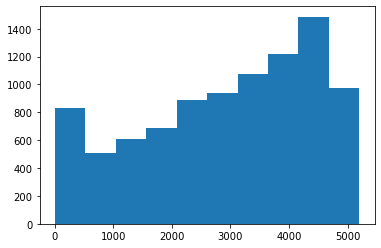

In [11]:
column_name = columns[3]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()

BMI has 123 missing entries


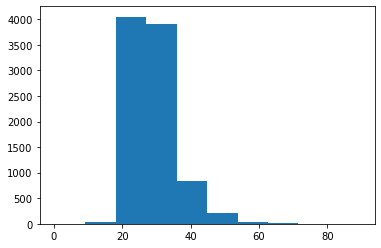

In [12]:
column_name = columns[4]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()
#print(result)

BMI >30 has 123 missing entries


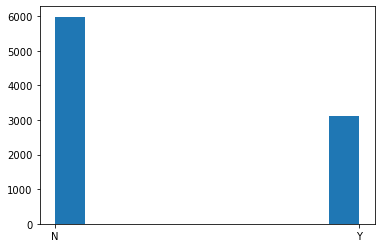

In [13]:
column_name = columns[5]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()

Sex has 0 missing entries


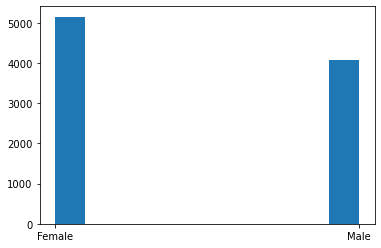

In [14]:
column_name = columns[6]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()

Age at CT has 0 missing entries


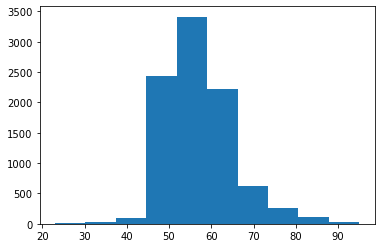

In [15]:
column_name = columns[7]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()
#print(result)

Tobacco has 608 missing entries


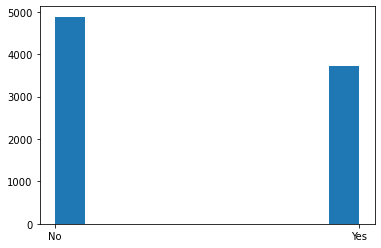

{'Yes', 'No'}


In [16]:
column_name = columns[8]
result, missing, special = removenan(data2[column_name])
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()
print(set(result))

FRS 10-year risk (%) has 0 missing entries
FRS 10-year risk (%) has 608 special entries


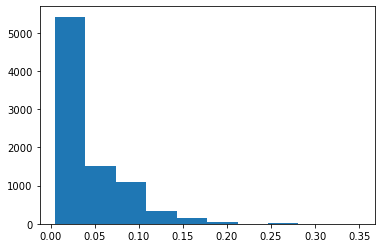

In [17]:
column_name = columns[9]
result, missing, special = removenan(data2[column_name], sorting=False, specialStr='X')
print(f'{column_name} has {len(missing)} missing entries')
print(f'{column_name} has {len(special)} special entries')

# replace '<1%' with 0.5%, and '>30%' with 35%
for i in range(len(result)):
    if result[i]=='<1%':
        result[i] = 0.005
    elif result[i]=='>30%':
        result[i] = 0.35
result.sort()        

plt.hist(result)
plt.show()
#print(result)

FRAX 10y Fx Prob (Orange-w/ DXA) has 0 missing entries
FRAX 10y Fx Prob (Orange-w/ DXA) has 123 special entries


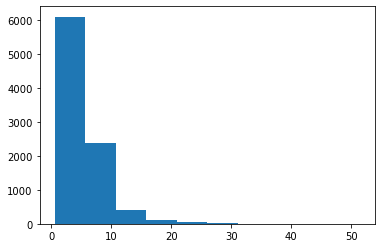

In [18]:
column_name = columns[10]
result, missing, special = removenan(data2[column_name], sorting=True, specialStr='_')
print(f'{column_name} has {len(missing)} missing entries')
print(f'{column_name} has {len(special)} special entries')
plt.hist(result)
plt.show()
#print(result)

FRAX 10y Hip Fx Prob (Orange-w/ DXA) has 0 missing entries
FRAX 10y Hip Fx Prob (Orange-w/ DXA) has 123 special entries


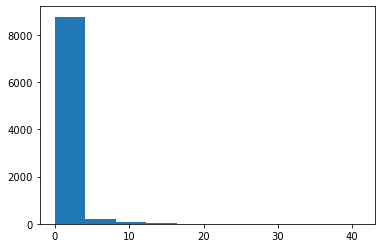

In [19]:
column_name = columns[11]
result, missing, special = removenan(data2[column_name], sorting=True, specialStr='_')
print(f'{column_name} has {len(missing)} missing entries')
print(f'{column_name} has {len(special)} special entries')
plt.hist(result)
plt.show()
#print(result)

Met Sx has 1438 missing entries


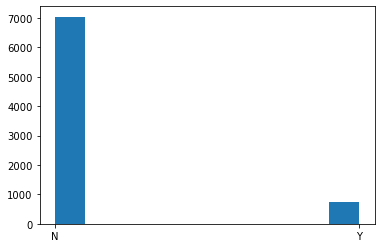

{'Y', 'N'}


In [20]:
column_name = columns[12]
result, missing, special = removenan(data2[column_name], sorting=True)
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()
print(set(result))

AA_FLAG has 0 missing entries


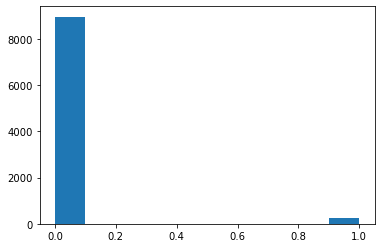

{0, 1}


In [21]:
column_name = columns[13]
result, missing, special = removenan(data2[column_name], sorting=True)
print(f'{column_name} has {len(missing)} missing entries')
plt.hist(result)
plt.show()
print(set(result))

# Data Cleaning

In [22]:
data3 = data2.copy()

# BMI - Remove Outliers (Less than 10 and those with Missing values)
data3 = data3[ (data3["BMI"] > 10)]

# BMI > 30 - Check to make sure this is all the missing values in the "BMI > 30" column (it is)
#print(len(data3[ (data3["BMI >30"].isna())])) # We rmoved all NAs from this group

# Tobacco - Create new category for the NAs
data3["Tobacco"] = data3["Tobacco"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Met Sx - Create new category for the NAs
data3["Met Sx"] = data3["Met Sx"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Remove Rows wth Special Characters
data3 = data3[ (data3["FRS 10-year risk (%)"] !=  "X")]
data3 = data3[ (data3["FRAX 10y Fx Prob (Orange-w/ DXA)"] !=  "_")]
data3 = data3[ (data3["FRAX 10y Hip Fx Prob (Orange-w/ DXA)"] !=  "_")]

# Turn these into numeric
data3.loc[(data3["FRS 10-year risk (%)"] == "<1%"),"FRS 10-year risk (%)"] = .005
data3.loc[(data3["FRS 10-year risk (%)"] == ">30%"),"FRS 10-year risk (%)"] = .35

# Remove ID columns becuase no value added
data3 = data3.drop(["Record ID","Visit ID" , "PT ID"],axis = 1)

# Convert remaining blanks to NA
data3  = data3.replace("", np.nan, regex=True) # Replace Blanks with NAs
data3  = data3.replace(" ", np.nan, regex=True) # Replace Blanks with NAs

# turn binary str result to 0 and 1
data3.loc[(data3["BMI >30"]=='N'),"BMI >30"] = 0
data3.loc[(data3["BMI >30"]=='Y'),"BMI >30"] = 1
data3.loc[(data3["Sex"]=='Female'),"Sex"] = 0
data3.loc[(data3["Sex"]=='Male'),"Sex"] = 1
data3.loc[(data3["Tobacco"]=='No'),"Tobacco"] = 0
data3.loc[(data3["Tobacco"]=='Yes'),"Tobacco"] = 1
data3.loc[(data3["Met Sx"]=='N'),"Met Sx"] = 0
data3.loc[(data3["Met Sx"]=='Y'),"Met Sx"] = 1


rmv = len(data2) - len(data3)
print(str(rmv) + " Removed (" + str(round(rmv*100/len(data2),2)) + "% of data)")

752 Removed (8.15% of data)


In [23]:
bone_measures = ["L1_HU_BMD"]

fat_measures = ["TAT Area (cm2)","Total Body                Area EA (cm2)", "VAT Area (cm2)", "SAT Area (cm2)", "VAT/SAT     Ratio" ]

muscle_measures = ["Muscle HU", " Muscle Area (cm2)", "L3 SMI (cm2/m2)"]

aortic_measures = ["AoCa        Agatston"]

liver_measures = ["Liver HU    (Median)"]

measures = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures]
measures_all = bone_measures + fat_measures + muscle_measures + aortic_measures + liver_measures


clinical_measures = ["Clinical F/U interval  [d from CT]", "BMI", "BMI >30", "Sex", "Age at CT", "Tobacco", "FRS 10-year risk (%)", "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "Met Sx", "AA_FLAG",]
clinical_measures_1 = ["Clinical F/U interval  [d from CT]", "BMI", "BMI >30", "Sex", "Age at CT"]
clinical_measures_2 = ["Tobacco", "FRS 10-year risk (%)", "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "Met Sx", "AA_FLAG"]
measures1 = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures,clinical_measures]
ct_clinical_measure = measures_all + clinical_measures
ct_clinical_measure_1 = measures_all + clinical_measures_1
ct_clinical_measure_2 = measures_all + clinical_measures_2


In [24]:
data_cleaned = data3.copy()
for mea in measures1:
    for m in mea:
        data_cleaned = data_cleaned[(data_cleaned[m] != "") & (data_cleaned[m].isnull() == False)]

rmv = len(data2)-len(data_cleaned)
print(rmv, "Remove (" + str(round(rmv*100/len(data2),2)) + "% of data)")



# Aproxx Equal Outcomes in Each Fold
Folds = 5
random.seed(1)
data_cleaned = data_cleaned.sample(frac=1)
data_cleaned = data_cleaned.sort_values(["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"]) 
data_cleaned = data_cleaned.sort_values("DEATH_FLAG")
data_cleaned = data_cleaned.reset_index() 
data_cleaned["Fold"] = data_cleaned.index % Folds
data_cleaned


2174 Remove (23.57% of data)


/home/jonathan/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,index,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,AoCa Agatston,Liver HU (Median),CARD_FLAG,DIA_FLAG,FEM_FLAG,ALZ_FLAG,CANCER_FLAG,OUTCOME_FLAGS,DEATH_FLAG,Fold
0,8968,0,25.1,0,1,63,0,0.060,5.36,0.58,...,44.505,61.0,0,0,0,0,0,0,0,0
1,4199,3292,29.0,0,0,60,0,0.010,6.60,0.19,...,172.375,40.0,0,1,0,0,0,1,0,1
2,2928,3273,29.0,0,0,54,0,0.005,4.93,0.10,...,0.000,62.0,0,1,0,0,0,1,0,2
3,8075,1983,42.5,1,0,59,0,0.010,5.55,0.19,...,3032.905,47.0,0,1,0,0,0,1,0,3
4,7246,2950,53.7,1,1,74,1,0.250,3.97,1.18,...,234.365,54.0,0,1,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,3519,3241,25.3,0,0,77,0,0.040,27.99,9.45,...,352.167,57.0,1,0,1,0,0,2,1,4
7045,4456,4713,22.1,0,0,86,0,0.040,32.92,20.35,...,22207.434,54.0,1,0,1,0,0,2,1,0
7046,8185,1977,24.8,0,1,93,0,0.100,8.75,5.40,...,4508.328,54.0,1,0,1,0,0,2,1,1
7047,4659,395,21.5,0,0,56,1,0.020,6.63,0.91,...,95.833,45.0,0,0,0,0,1,1,1,2


## CT Prediction

In [25]:
def LR(train,test,X_col=measures_all):

    ct_train_x = train.loc[:,X_col]
    ct_train_y = train.loc[:,"DEATH_FLAG"]
    ct_test_x = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]

    clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train_x, ct_train_y)
    pred_y = clf_ct_LR.predict_proba(ct_test_x)
    prob_y_LR = [i[1] for i in pred_y]
    
    return prob_y_LR,ct_test_y

In [26]:
AUCs_LR = []
FPR_LR = []
TPR_LR = []
TH_LR = []

for f in range(Folds):
    prob_y,true_y = LR(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                data_cleaned.loc[(data_cleaned["Fold"] == f),])
     
    fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
    auc = metrics.roc_auc_score(true_y,prob_y)
    AUCs_LR.append(auc) 
    FPR_LR.append(fpr) 
    TPR_LR.append(tpr) 
    TH_LR.append(thresholds) 
    

In [27]:
def RF2(train,test,d,X_col=measures_all):
    
    ct_train_x = train.loc[:,X_col]
    ct_train_y = train.loc[:,"DEATH_FLAG"]
    ct_test_x = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
    
    clf_ct = RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train_x, ct_train_y)
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_RF = [i[1] for i in pred_y]
            
    return list(prob_y_RF),list(ct_test_y)
    

In [28]:
def LR_RF2(tr1,tr2,test,d,X_col=measures_all):

    ct_train2_x = tr2.loc[:,X_col]
    ct_train2_x_temp = tr2.loc[:,X_col]
    ct_train2_y = tr2.loc[:,"DEATH_FLAG"]

    ct_test_x = test.loc[:,X_col]
    ct_test_x_temp = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
        
    Flags = ["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"] 
    
    
    
    for f in Flags:
        ct_train1_x = tr1.loc[:,X_col]
        ct_train1_y = tr1.loc[:,f]
        clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train1_x, ct_train1_y)
        #clf_ct_LR =  RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
        
        pred_y = clf_ct_LR.predict_proba(ct_train2_x_temp)
        prob_y_LR = [i[1]for i in pred_y]
        ct_train2_x[f+"_PRED"] = prob_y_LR.copy()

        pred_y = clf_ct_LR.predict_proba(ct_test_x_temp)
        prob_y_LR = [i[1] for i in pred_y]
        ct_test_x[f+"_PRED"] = prob_y_LR.copy()
        

    clf_ct = RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
    #lf_ct = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train2_x, ct_train2_y)
    
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_LR_RF = [i[1] for i in pred_y]

    return list(prob_y_LR_RF),list(ct_test_y)

In [29]:
def LR_RF3(tr1,tr2,test,d,X_col=measures_all):
        
    ct_train2_x = tr2.loc[:,X_col]
    ct_train2_x_temp = tr2.loc[:,X_col]
    ct_train2_y = tr2.loc[:,"DEATH_FLAG"]

    ct_test_x = test.loc[:,X_col]
    ct_test_x_temp = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
        
    Flags = ["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"] 
    
    
    
    for f in Flags:
        ct_train1_x = tr1.loc[:,X_col]
        ct_train1_y = tr1.loc[:,f]
        #clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train1_x, ct_train1_y)
        clf_ct_LR =  RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train1_x, ct_train1_y)
        
        pred_y = clf_ct_LR.predict_proba(ct_train2_x_temp)
        prob_y_LR = [i[1]for i in pred_y]
        ct_train2_x[f+"_PRED"] = prob_y_LR.copy()

        pred_y = clf_ct_LR.predict_proba(ct_test_x_temp)
        prob_y_LR = [i[1] for i in pred_y]
        ct_test_x[f+"_PRED"] = prob_y_LR.copy()
        

    #clf_ct = RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
    clf_ct = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train2_x, ct_train2_y)
    
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_LR_RF = [i[1] for i in pred_y]

    return list(prob_y_LR_RF),list(ct_test_y)

In [30]:
D = [3,5]

AUCs_RF_All = []
FPR_RF_All =[]
TPR_RF_All =[]
TH_RF_All = []

for d in D:
    AUCs_RF = []
    FPR_RF =[]
    TPR_RF =[]
    TH_RF = []
    for f in range(Folds):
        print(f)
        prob_y,true_y = RF2(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                 data_cleaned.loc[(data_cleaned["Fold"] == f),],
                                 d)
     
        fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
        auc = metrics.roc_auc_score(true_y,prob_y)
        AUCs_RF.append(auc) 
        FPR_RF.append(fpr) 
        TPR_RF.append(tpr) 
        TH_RF.append(thresholds) 
    
    AUCs_RF_All.append(AUCs_RF)
    FPR_RF_All.append(FPR_RF)
    TPR_RF_All.append(TPR_RF)
    TH_RF_All.append(TH_RF)



0
1
2
3
4
0
1
2
3
4


In [31]:
AUCs_LR_RF_All = []
FPR_LR_RF_All =[]
TPR_LR_RF_All =[]
TH_LR_RF_All = []

for d in D:
    AUCs_LR_RF = []
    FPR_LR_RF =[]
    TPR_LR_RF =[]
    TH_LR_RF = []
    for f in range(Folds):
        print(f)
        Train_Folds = [ff for ff in range(Folds) if ff != f]
        combs = combinations(Train_Folds, math.ceil((Folds-1)*.5))
        
        for c in combs:
            c= list(c)
            prob_y,true_y = LR_RF2(data_cleaned.loc[(data_cleaned["Fold"] != f) & (data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] != f) & (~data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] == f)],
                                  d)

            fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
            auc = metrics.roc_auc_score(true_y,prob_y)
            AUCs_LR_RF.append(auc) 
            FPR_LR_RF.append(fpr) 
            TPR_LR_RF.append(tpr) 
            TH_LR_RF.append(thresholds) 
    
    AUCs_LR_RF_All.append(AUCs_LR_RF)
    FPR_LR_RF_All.append(FPR_LR_RF)
    TPR_LR_RF_All.append(TPR_LR_RF)
    TH_LR_RF_All.append(TH_LR_RF)


0
1
2
3
4
0
1
2
3
4


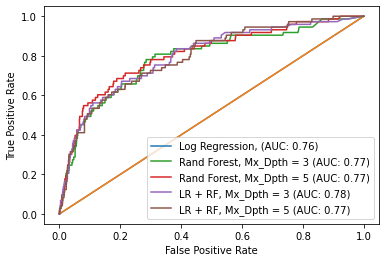

In [32]:
plt.plot(FPR_LR[0], FPR_LR[0], label='Log Regression, (AUC: ' + str(round(sum(AUCs_LR)/len(AUCs_LR),2))+')')
plt.plot([0,1],[0,1])

for d in range(len(D)):
    plt.plot(FPR_RF_All[d][0], TPR_RF_All[d][0], label='Rand Forest, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_All[d])/len(AUCs_RF_All[d]),2))+')')

for d in range(len(D)):
    plt.plot(FPR_LR_RF_All[d][0], TPR_LR_RF_All[d][0], label='LR + RF, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_LR_RF_All[d])/len(AUCs_LR_RF_All[d]),2))+')')

#for d in range(len(D)):
#    plt.plot(FPR_RF_LR_All[d][0], TPR_RF_LR_All[d][0], label='RF + LR, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_LR_All[d])/len(AUCs_RF_LR_All[d]),2))+')')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

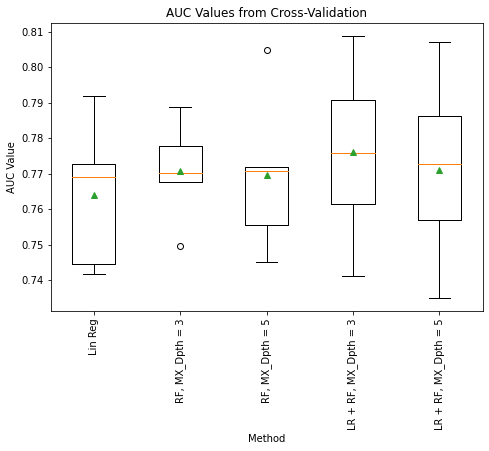

In [33]:

data = [AUCs_LR] +  [ AUCs_RF_All[d] for d in range(len(D))] + [ AUCs_LR_RF_All[d] for d in range(len(D))] 
Labs = ["Lin Reg"] + [ "RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] + [ "LR + RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] 
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data,showmeans=True)

ax.set_title('AUC Values from Cross-Validation')
ax.set_xlabel('Method')
ax.set_ylabel('AUC Value')

plt.xticks(list(range(1,1+len(data))), Labs)
ax.set_xticklabels(Labs, rotation = 90)
 
# show plot
plt.show()

In [34]:
#daskh

## CT + CLINICAL PREDICTION

In [48]:
AUCs_LR = []
FPR_LR = []
TPR_LR = []
TH_LR = []

for f in range(Folds):
    prob_y,true_y = LR(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                data_cleaned.loc[(data_cleaned["Fold"] == f),],X_col=ct_clinical_measure_2)
     
    fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
    auc = metrics.roc_auc_score(true_y,prob_y)
    AUCs_LR.append(auc) 
    FPR_LR.append(fpr) 
    TPR_LR.append(tpr) 
    TH_LR.append(thresholds) 

In [49]:
D = [3,5]

AUCs_RF_All = []
FPR_RF_All =[]
TPR_RF_All =[]
TH_RF_All = []

for d in D:
    AUCs_RF = []
    FPR_RF =[]
    TPR_RF =[]
    TH_RF = []
    for f in range(Folds):
        print(f)
        prob_y,true_y = RF2(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                 data_cleaned.loc[(data_cleaned["Fold"] == f),],
                                 d,X_col=ct_clinical_measure_2)
     
        fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
        auc = metrics.roc_auc_score(true_y,prob_y)
        AUCs_RF.append(auc) 
        FPR_RF.append(fpr) 
        TPR_RF.append(tpr) 
        TH_RF.append(thresholds) 
    
    AUCs_RF_All.append(AUCs_RF)
    FPR_RF_All.append(FPR_RF)
    TPR_RF_All.append(TPR_RF)
    TH_RF_All.append(TH_RF)


0
1
2
3
4
0
1
2
3
4


In [50]:
AUCs_LR_RF_All = []
FPR_LR_RF_All =[]
TPR_LR_RF_All =[]
TH_LR_RF_All = []

for d in D:
    AUCs_LR_RF = []
    FPR_LR_RF =[]
    TPR_LR_RF =[]
    TH_LR_RF = []
    for f in range(Folds):
        print(f)
        Train_Folds = [ff for ff in range(Folds) if ff != f]
        combs = combinations(Train_Folds, math.ceil((Folds-1)*.5))
        
        for c in combs:
            c= list(c)
            prob_y,true_y = LR_RF2(data_cleaned.loc[(data_cleaned["Fold"] != f) & (data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] != f) & (~data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] == f)],
                                  d,X_col=ct_clinical_measure_2)

            fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
            auc = metrics.roc_auc_score(true_y,prob_y)
            AUCs_LR_RF.append(auc) 
            FPR_LR_RF.append(fpr) 
            TPR_LR_RF.append(tpr) 
            TH_LR_RF.append(thresholds) 
    
    AUCs_LR_RF_All.append(AUCs_LR_RF)
    FPR_LR_RF_All.append(FPR_LR_RF)
    TPR_LR_RF_All.append(TPR_LR_RF)
    TH_LR_RF_All.append(TH_LR_RF)

0
1
2
3
4
0
1
2
3
4


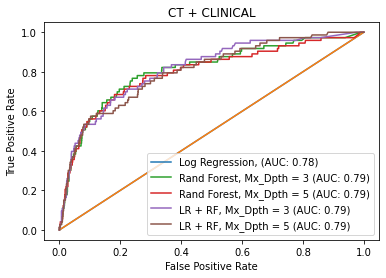

In [51]:
plt.plot(FPR_LR[0], FPR_LR[0], label='Log Regression, (AUC: ' + str(round(sum(AUCs_LR)/len(AUCs_LR),2))+')')
plt.plot([0,1],[0,1])

for d in range(len(D)):
    plt.plot(FPR_RF_All[d][0], TPR_RF_All[d][0], label='Rand Forest, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_All[d])/len(AUCs_RF_All[d]),2))+')')

for d in range(len(D)):
    plt.plot(FPR_LR_RF_All[d][0], TPR_LR_RF_All[d][0], label='LR + RF, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_LR_RF_All[d])/len(AUCs_LR_RF_All[d]),2))+')')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CT + CLINICAL")
plt.legend()
plt.show()

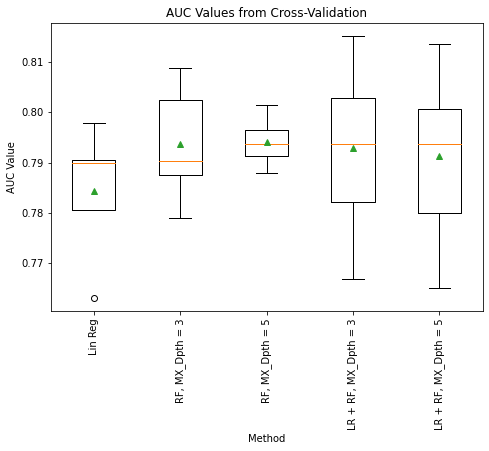

In [52]:
data = [AUCs_LR] +  [ AUCs_RF_All[d] for d in range(len(D))] + [ AUCs_LR_RF_All[d] for d in range(len(D))]
Labs = ["Lin Reg"] + [ "RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] + [ "LR + RF, MX_Dpth = " + str(D[d]) for d in range(len(D))]
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data,showmeans=True)

ax.set_title('AUC Values from Cross-Validation')
ax.set_xlabel('Method')
ax.set_ylabel('AUC Value')

plt.xticks(list(range(1,1+len(data))), Labs)
ax.set_xticklabels(Labs, rotation = 90)
 
# show plot
plt.show()

## BIO AGE CALCS

In [40]:
def NN_Age(df,cols,k):
    df = data_cleaned2 
    k = 10
    
    cols2 = cols + ["Age at CT","Sex"]
    df2 = df.loc[:,cols2]


    for r in df2.index:
        df2["dist"] = 0
        
        s = df2.loc[r,"Sex"]
        df3 = df2.loc[(df2.loc[:,"Sex"] == s),:].copy()
        
        for c in cols:
            df3[c] = df3[c]/df3[c].std()
        a = df3.loc[r,cols]
        for c in cols:
            df3.loc[:,"dist"] += (df3.loc[:,c] - float(df2.loc[r,c]))**2

        df3.loc[r,"dist"] = 10000000000000 
        
        df3 = df3.sort_values("dist")
        df2.loc[r,"pred_age"] = (df3["Age at CT"].iloc[0:k]).mean()
        
    print("done")
    return df2["pred_age"] 


### Use NN to get age of various health systems

In [41]:
data_cleaned3 = data_cleaned2.copy()
data_cleaned3["Bone_Bio_Age"] = NN_Age(data_cleaned3,bone_measures,10)
data_cleaned3["Fat_Bio_Age"] = NN_Age(data_cleaned3,fat_measures,10)
data_cleaned3["Muscle_Bio_Age"] = NN_Age(data_cleaned3,muscle_measures,10)
data_cleaned3["Aortic_Bio_Age"] = NN_Age(data_cleaned3,aortic_measures,10)
data_cleaned3["Liver_Bio_Age"] = NN_Age(data_cleaned3,liver_measures,10)

data_cleaned3

NameError: name 'data_cleaned2' is not defined

### Use results of NN to Predict Age Using Lin Regression. We use Lin Regression so Weight Can be varied. Note Gender Split

In [ ]:
age_measures = ["Bone_Bio_Age","Fat_Bio_Age","Muscle_Bio_Age","Aortic_Bio_Age","Liver_Bio_Age"]

Females_Data = data_cleaned3.loc[(data_cleaned3["Sex"] == "Female"),:]
Males_Data = data_cleaned3.loc[(data_cleaned3["Sex"] != "Female"),:]

reg_Female = LinearRegression().fit(Females_Data[age_measures],Females_Data["Age at CT"])
reg_Male = LinearRegression().fit(Males_Data [age_measures],Males_Data ["Age at CT"])


print("Female Model")
print("Score:",reg_Female.score(Females_Data[age_measures],Females_Data["Age at CT"]))
print("Int:",reg_Female.intercept_)
print("Coef:",reg_Female.coef_)
print("")
print("Male Model")
print("Score:",reg_Male.score(Males_Data[age_measures],Males_Data["Age at CT"]))
print("Int:",reg_Male.intercept_)
print("Coef:",reg_Male.coef_)

data_cleaned3.loc[:,"Bio_Age"] = 0
data_cleaned3.loc[(data_cleaned3["Sex"] != "Female"),"Bio_Age"] = reg_Male.predict(np.array(Males_Data[age_measures]))
data_cleaned3.loc[(data_cleaned3["Sex"] == "Female"),"Bio_Age"] = reg_Female.predict(np.array(Females_Data[age_measures]))

data_cleaned3["Age_Adjustment_Days"] = 0
data_cleaned3["Age_Adjustment_Days"] = (data_cleaned3["Bio_Age"] - data_cleaned3["Age at CT"])*365

data_cleaned3